# **THE SPARKS FOUNDATION**
##Authure : Lajmi Syrine
##Data Science & Business Analytics
#TASK 7 : Stock Market Prediction using Numerical and Textual Analysis
OBJECTIVE : Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import math

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


##Finace Data

In [2]:
df=pd.read_csv("/content/CSV.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-09,46.639999,47.840000,46.299999,46.299999,45.809258,174400
1,2021-09-10,46.369999,46.439999,45.770000,46.099998,45.611378,109500
2,2021-09-13,46.099998,46.230000,45.299999,45.580002,45.096889,148000
3,2021-09-14,45.500000,45.529999,45.009998,45.169998,44.691235,164700
4,2021-09-15,45.020000,45.700001,45.020000,45.270000,44.790180,136000


#Exploring data

In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,47.036865,47.770437,46.287698,46.981746,46.681583,140558.730159
std,7.231083,7.343175,7.168582,7.244134,7.116208,75489.486638
min,34.540001,35.400002,34.220001,34.240002,34.127003,27900.000000
25%,40.202501,40.822501,39.684999,40.334999,40.222575,86750.000000
50%,46.504999,48.280000,45.735000,46.199998,45.710318,124900.000000
75%,51.997501,52.730000,51.299999,52.017500,51.639660,179700.000000
max,65.910004,66.330002,64.830002,65.910004,65.362144,602800.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [5]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
# Dropping off the NaN values as we won't be needing them during modelling
df.dropna(inplace=True)

In [7]:
# Since the datatype of 'date' is object. We need to convert it to datetime.
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-09,46.639999,47.840000,46.299999,46.299999,45.809258,174400
1,2021-09-10,46.369999,46.439999,45.770000,46.099998,45.611378,109500
2,2021-09-13,46.099998,46.230000,45.299999,45.580002,45.096889,148000
3,2021-09-14,45.500000,45.529999,45.009998,45.169998,44.691235,164700
4,2021-09-15,45.020000,45.700001,45.020000,45.270000,44.790180,136000
...,...,...,...,...,...,...,...
247,2022-09-01,35.200001,36.180000,35.070000,35.660000,35.660000,92500
248,2022-09-02,36.209999,36.320000,35.410000,35.680000,35.680000,70700
249,2022-09-06,35.950001,35.950001,34.840000,35.270000,35.270000,74500
250,2022-09-07,35.349998,35.669998,34.810001,35.610001,35.610001,63700


#Visualizing the historical stock market dataset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


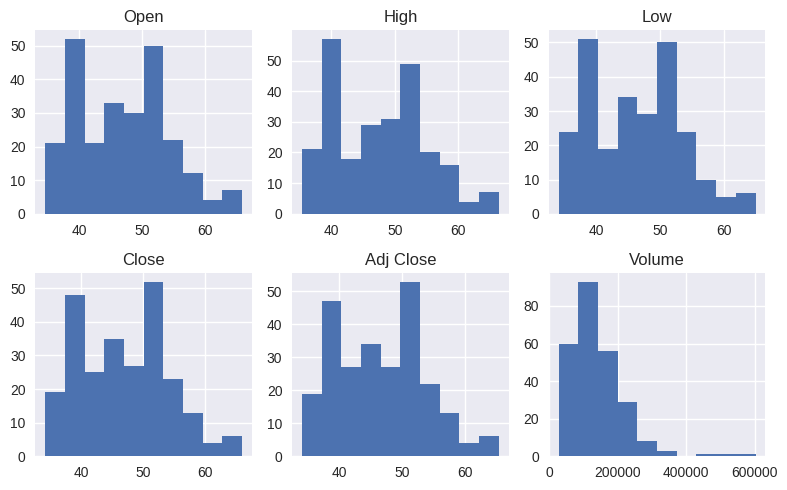

In [8]:
# Graphical representation of the distribution of each column of dataset
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

df.loc[:, df.columns != 'Date'].hist(ax=ax, layout=(2, 3));
plt.tight_layout();

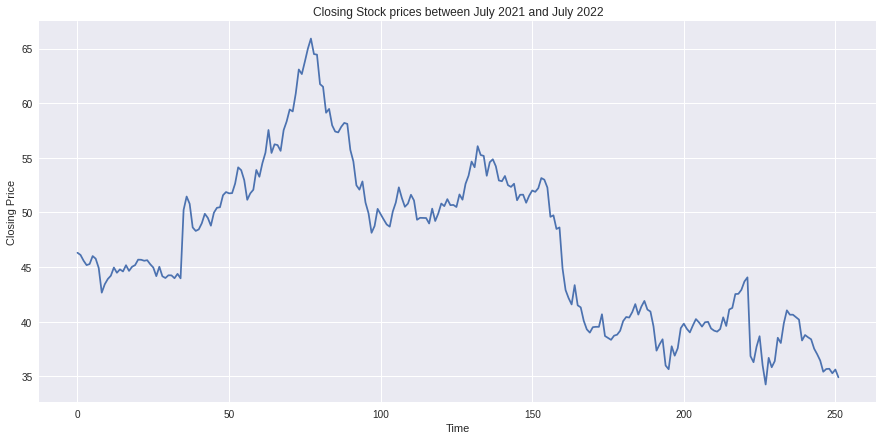

In [9]:
# Closing Prices
df['Close'].plot(figsize=(15, 7));
plt.title("Closing Stock prices between July 2021 and July 2022")
plt.ylabel("Closing Price")
plt.xlabel("Time");

## Loading the news-headlines dataset

In [10]:
# Read the news headlines dataset
df1 = pd.read_csv(r"/content/india-news-headlines.csv")
df1 = df1.dropna(axis = 0, how ='any')
df1.tail()

,publish_date,headline_category,headline_text
51628,20011210,city.chandigarh,Morcha finds following at first major rally
51629,20011210,city.bengaluru,Deflated tyre causes tension in Hubli
51630,20011210,city.patna,Nitish for change in minimum support price scheme
51631,20011210,city.pune,State govt under fire over devdasi system
51632,20011210,city.bengaluru,Question mark over water for Bellary thermal p...


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51633 entries, 0 to 51632
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   publish_date       51633 non-null  int64 
 1   headline_category  51633 non-null  object
 2   headline_text      51633 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [12]:
df1.value_counts()

publish_date  headline_category  headline_text                                      
20010105      unknown            Bush names Lindsey top economic aide                   6
                                 Light combat craft takes India into club class         6
20010104      unknown            Bangla Oppn leader issues 'fatwa' against judges       5
20010530      unknown            Feroz Shah to repeat Kartoos?                          4
20010105      unknown            Indian American boy confesses to parents' murder       4
                                                                                       ..
20010823      city.ahmedabad     For GeneratioNext; politics is still a dirty career    1
                                 GEB draws up plan to electrify 5 lakh hutments         1
                                 Gandhians harbour doubts on BBC film                   1
                                 Glider on world trip arrives in Ahmedabad              1
20011210      c

# Preprocessing the dataset for modelling

In [13]:
# Drop 0 values, and the Category column as we don't require this for our analysis.
df1.drop('headline_category', axis = 1, inplace=True)

In [18]:
# Convert the date column to the specified date-type.
df1['publish_date'] = pd.to_datetime(df1['publish_date'],format='%Y%m%d')
df1

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic
...,...,...
51628,2001-12-10,Morcha finds following at first major rally
51629,2001-12-10,Deflated tyre causes tension in Hubli
51630,2001-12-10,Nitish for change in minimum support price scheme
51631,2001-12-10,State govt under fire over devdasi system


In [19]:
# Renames the columns
df1. rename(columns = {'publish_date':'Date', 
                           'headline_text':'News'}, 
           inplace = True)

In [20]:
# Removes the duplicate data 
df1['News'] = df1.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df1 = df1.drop_duplicates() 
df1.reset_index(inplace = True, drop = True)
df1

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
296,2001-12-06,HERE COMES THE PARTY SEASON Remit2India to web...
297,2001-12-07,Armed forces get a pat from Governor; CM Miffe...
298,2001-12-08,Abhinav memorial chess tournament Sunny side u...
299,2001-12-09,Chrysanthemum; Coleus Show gets underway Demon...


#Clenaing the categorcial data

In [21]:
# Cleaning headlines
# removing unwanted characters from the News
df1.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
df1["News"].head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

In [22]:
!pip install wordcloud
from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


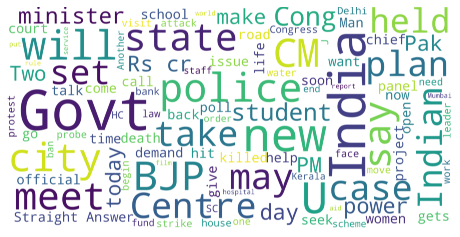

In [23]:
#identify the most used word 
word_cloud_text = ''.join(df1['News'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

# NLP: Sentimental Analysis on the news headlines


In [24]:
#Functions to get the subjectivity and polarity scores using TextBlob module
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity


In [25]:
#Adding subjectivity and polarity columns
df1['Subjectivity'] = df1['News'].apply(getSubjectivity)
df1['Polarity'] = df1['News'].apply(getPolarity)
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
296,2001-12-06,HERE COMES THE PARTY SEASON Remit India to web...,0.399500,0.072192
297,2001-12-07,Armed forces get a pat from Governor CM Miffe...,0.393678,0.063063
298,2001-12-08,Abhinav memorial chess tournament Sunny side u...,0.425275,0.100183
299,2001-12-09,Chrysanthemum Coleus Show gets underway Demon...,0.428235,0.096277


In [26]:
# Instantiating the sentiment analyzer
sia = SentimentIntensityAnalyzer()

df1['Compound'] = [sia.polarity_scores(v)['compound'] for v in df1['News']]
df1['Negative'] = [sia.polarity_scores(v)['neg'] for v in df1['News']]
df1['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df1['News']]
df1['Positive'] = [sia.polarity_scores(v)['pos'] for v in df1['News']]
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
296,2001-12-06,HERE COMES THE PARTY SEASON Remit India to web...,0.399500,0.072192,-0.9993,0.158,0.717,0.124
297,2001-12-07,Armed forces get a pat from Governor CM Miffe...,0.393678,0.063063,-0.9989,0.140,0.783,0.077
298,2001-12-08,Abhinav memorial chess tournament Sunny side u...,0.425275,0.100183,-0.9994,0.181,0.693,0.125
299,2001-12-09,Chrysanthemum Coleus Show gets underway Demon...,0.428235,0.096277,-0.9947,0.138,0.746,0.115


In [27]:
# Save the df_news dataset
df1.to_csv("df1.csv")
print("Saved successfully.")

Saved successfully.


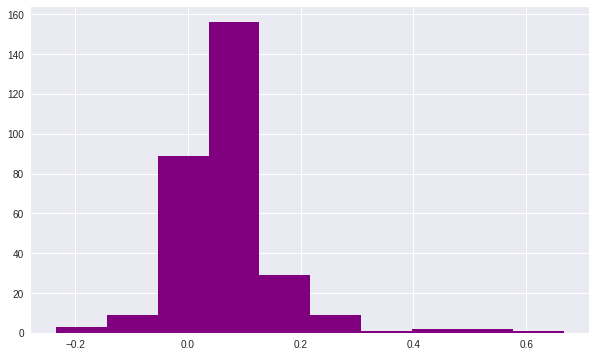

In [28]:
plt.figure(figsize = (10,6))
df1['Polarity'].hist(color = 'purple')

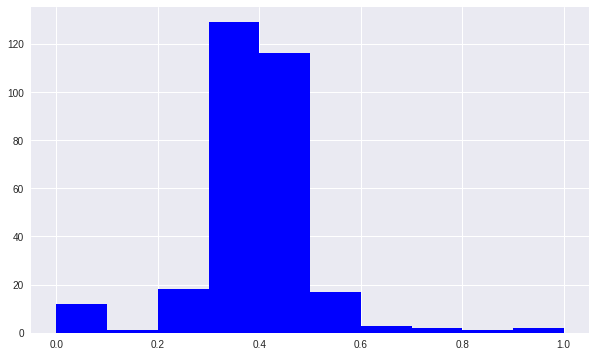

In [29]:
plt.figure(figsize = (10,6))
df1['Subjectivity'].hist(color = 'blue')

#Merging the 2 data:Preparing the final dataset
We'll prepare the final dataset by combining the sentimental analysis results with the historical prices data for predicting the stock prices using Multivariate Time Series Forecasting.

In [30]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-09,46.639999,47.840000,46.299999,46.299999,45.809258,174400
1,2021-09-10,46.369999,46.439999,45.770000,46.099998,45.611378,109500
2,2021-09-13,46.099998,46.230000,45.299999,45.580002,45.096889,148000
3,2021-09-14,45.500000,45.529999,45.009998,45.169998,44.691235,164700
4,2021-09-15,45.020000,45.700001,45.020000,45.270000,44.790180,136000
...,...,...,...,...,...,...,...
247,2022-09-01,35.200001,36.180000,35.070000,35.660000,35.660000,92500
248,2022-09-02,36.209999,36.320000,35.410000,35.680000,35.680000,70700
249,2022-09-06,35.950001,35.950001,34.840000,35.270000,35.270000,74500
250,2022-09-07,35.349998,35.669998,34.810001,35.610001,35.610001,63700


In [31]:
df1

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
296,2001-12-06,HERE COMES THE PARTY SEASON Remit India to web...,0.399500,0.072192,-0.9993,0.158,0.717,0.124
297,2001-12-07,Armed forces get a pat from Governor CM Miffe...,0.393678,0.063063,-0.9989,0.140,0.783,0.077
298,2001-12-08,Abhinav memorial chess tournament Sunny side u...,0.425275,0.100183,-0.9994,0.181,0.693,0.125
299,2001-12-09,Chrysanthemum Coleus Show gets underway Demon...,0.428235,0.096277,-0.9947,0.138,0.746,0.115


In [39]:
df_merge=pd.concat([df,df1],axis=1)
df_merge.dropna(axis=0, inplace=True)
df_merge.drop(['Date', 'News'], axis=1, inplace=True)
df_merge

,Open,High,Low,Close,Adj Close,Volume,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,46.639999,47.840000,46.299999,46.299999,45.809258,174400.0,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,46.369999,46.439999,45.770000,46.099998,45.611378,109500.0,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,46.099998,46.230000,45.299999,45.580002,45.096889,148000.0,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,45.500000,45.529999,45.009998,45.169998,44.691235,164700.0,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,45.020000,45.700001,45.020000,45.270000,44.790180,136000.0,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...,...,...,...,...
247,35.200001,36.180000,35.070000,35.660000,35.660000,92500.0,0.413357,0.061974,-0.9983,0.151,0.755,0.094
248,36.209999,36.320000,35.410000,35.680000,35.680000,70700.0,0.366605,-0.026313,-0.9993,0.167,0.765,0.069
249,35.950001,35.950001,34.840000,35.270000,35.270000,74500.0,0.328720,0.018091,-0.9994,0.150,0.788,0.062
250,35.349998,35.669998,34.810001,35.610001,35.610001,63700.0,0.400176,0.000460,-0.9987,0.149,0.775,0.076


In [40]:
df_final = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df_final

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,46.299999,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,46.099998,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,45.580002,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,45.169998,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,45.270000,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...
247,35.660000,0.413357,0.061974,-0.9983,0.151,0.755,0.094
248,35.680000,0.366605,-0.026313,-0.9993,0.167,0.765,0.069
249,35.270000,0.328720,0.018091,-0.9994,0.150,0.788,0.062
250,35.610001,0.400176,0.000460,-0.9987,0.149,0.775,0.076


#Split data

In [41]:
from sklearn.model_selection import train_test_split
# Create X & y variables for Machine Learning
X = df_final.drop(["Close"], axis=1)
y = df_final[["Close"]]

# Create a train-test split of these variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [42]:
print("x_train shape: {}".format(X_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(X_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (201, 6)
y_train shape: (201, 1)

x_test shape: (51, 6)
y_test shape: (51, 1)



In [43]:
# Label encode the target variable 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#Feature Scaling using MinMaxScaler¶


In [44]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
df_scaled = pd.DataFrame(sc.fit_transform(df_final))
df_scaled.columns = df_final.columns
df_scaled.index = df_final.index
df_scaled.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.380802,0.286859,0.418803,0.010411,0.272523,0.809,0.116776
1,0.374487,0.392857,0.358466,0.054770,0.351351,0.735,0.179276
2,0.358068,0.445360,0.362636,0.882261,0.234234,0.792,0.171053
3,0.345121,0.480553,0.552619,0.987980,0.319820,0.694,0.269737
4,0.348279,0.439394,0.535354,0.084645,0.481982,0.655,0.215461


#Create Hybrid Model


In [45]:
X=df_scaled.drop("Close",axis=1)
y=df_scaled["Close"]

#train and test data

In [46]:
 #shuffle and split training and test sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [47]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn import metrics

#Random Forest

In [48]:
## Using Random Forest Regression
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf=rf.predict(X_test)

mse_rf = metrics.mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print("Random Forest Model RMSE: ",rmse_rf)

Random Forest Model RMSE:  0.15791983830939502


#Xgboost

In [49]:
!pip install xgboost
from xgboost import XGBRegressor
xgb = XGBRegressor(colsample_bytree = 0.6, 
                         learning_rate = 0.01, 
                         max_depth = 2, 
                         n_estimators = 1000) 
xgb.fit(X_train, y_train)
y_pred_xgb=xgb.predict(X_test)

mse_xgb = metrics.mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print("XGB Model RMSE: ",rmse_xgb)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[13:33:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB Model RMSE:  0.15874517094775636


##AdaBoost


In [50]:
## Using AdaBoostRegressor
adb = AdaBoostRegressor()
adb.fit(X_train, y_train)
y_pred_adb=adb.predict(X_test)

mse_adb = metrics.mean_squared_error(y_test, y_pred_adb)
rmse_adb = np.sqrt(mse_adb)

print("AdaBoost Model RMSE: ",rmse_adb)

AdaBoost Model RMSE:  0.16091301204304784


After using AdaBoost model,Xgboost model,Random Forst model and calculte the RMSE of each one we can see that Random Forest model is the best one for this moodel.